In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import random 

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# CONFIG

**Set sample to False if you want to run algos on entire dataset**

In [3]:
CONFIG = {
    'sample': False,
    'sample_size': 100000,
    'random_state': 123,
    'target_col': 'delta',
    'n_jobs': 3,  # gridsearch parallelization, might need to adjust based on your system
    'ts_splits': 5, # TimeSeriesSplit number of splits
    'ts_gap': 48,  # 2-day gap
    'visualize_clusters': False
}

FEATURE_COLS = {
    'categorical': ['isHoliday', 'has_kiosk', 'weekday', 'weather_cluster', 'workhours', 'commute', 'free', 'night'],
    'drop': ['weather_code', 'datetime', 'station_name', 'arrivals', 'departures', 'num_docks_available', 'num_ebikes_available', 'capacity', 'cluster', 'sunset', 'sunrise']
}

# DATA LOADING

In [4]:
df = pd.read_parquet("data/final/df.parquet")
df.rename(columns={"hour": "datetime"}, inplace=True) # rename for later use

# REDUCE DATASET SIZE FOR DEVELOPMENT
if CONFIG['sample']:
    df = df.sample(CONFIG['sample_size'], random_state=CONFIG['random_state'])

In [5]:
# All remaining columns are considered numerical
FEATURE_COLS['numerical'] = [col for col in df.columns if col not in [CONFIG['target_col']] + FEATURE_COLS['categorical'] + FEATURE_COLS['drop']]

In [6]:
df.head()

,station_name,datetime,departures,arrivals,temperature_2m,weather_code,rain,precipitation,snowfall,cloud_cover,...,avg_arrivals_station_free,var_arrivals_station_free,avg_departures_station_free,var_departures_station_free,avg_delta_station_unfriendly_weather,var_delta_station_unfriendly_weather,avg_arrivals_station_unfriendly_weather,var_arrivals_station_unfriendly_weather,avg_departures_station_unfriendly_weather,var_departures_station_unfriendly_weather
0,10th & E St NW,2023-01-01 00:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
1,10th & E St NW,2023-01-01 01:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
2,10th & E St NW,2023-01-01 02:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
3,10th & E St NW,2023-01-01 03:00:00+00:00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
4,10th & E St NW,2023-01-01 04:00:00+00:00,0.0,0.0,11.936,51.0,0.2,0.2,0.0,20.0,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257


## -- BEGIN CENTRALIZE WITH PREPROCESSING --

In [7]:
# Simulate random cluster assignment (K=5) // not needed after actual clustering

# Get unique station names
unique_stations = df['station_name'].unique()

# Create a dictionary mapping stations to random clusters
random_clusters = {}
for station in unique_stations:
    random_clusters[station] = random.randint(1, 5)

# Map the random clusters to the dataframe
df['cluster'] = df['station_name'].map(random_clusters)

# Print the distribution of stations across clusters
print("Number of stations in each random cluster:")
print(df.groupby('cluster')['station_name'].nunique())

Number of stations in each random cluster:
cluster
1    150
2    156
3    138
4    143
5    151
Name: station_name, dtype: int64


**Question:** Is the unequal distribution a problem here?

In [8]:
# Time series feature engineering
def engineer_time_features(df, date_column='datetime'):
    # Make a copy to avoid warnings
    df = df.copy()
    
    # Extract date components
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['hour'] = df[date_column].dt.hour
    df['dayofweek'] = df[date_column].dt.dayofweek
    df['dayofyear'] = df[date_column].dt.dayofyear
    
    # Weekend flag
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # Cyclic encoding of time features (to capture periodicity)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofyear']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofyear']/365)
    
    return df

df_processed = engineer_time_features(df)
df_processed.head()

,station_name,datetime,departures,arrivals,temperature_2m,weather_code,rain,precipitation,snowfall,cloud_cover,...,hour,dayofweek,dayofyear,is_weekend,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos
0,10th & E St NW,2023-01-01 00:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,1,1,0.5,0.866025,0.000000,1.000000,0.017213,0.999852
1,10th & E St NW,2023-01-01 01:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,6,1,1,0.5,0.866025,0.258819,0.965926,0.017213,0.999852
2,10th & E St NW,2023-01-01 02:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,6,1,1,0.5,0.866025,0.500000,0.866025,0.017213,0.999852
3,10th & E St NW,2023-01-01 03:00:00+00:00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3,6,1,1,0.5,0.866025,0.707107,0.707107,0.017213,0.999852
4,10th & E St NW,2023-01-01 04:00:00+00:00,0.0,0.0,11.936,51.0,0.2,0.2,0.0,20.0,...,4,6,1,1,0.5,0.866025,0.866025,0.500000,0.017213,0.999852


## -- END CENTRALIZE WITH PREPROCESSING --

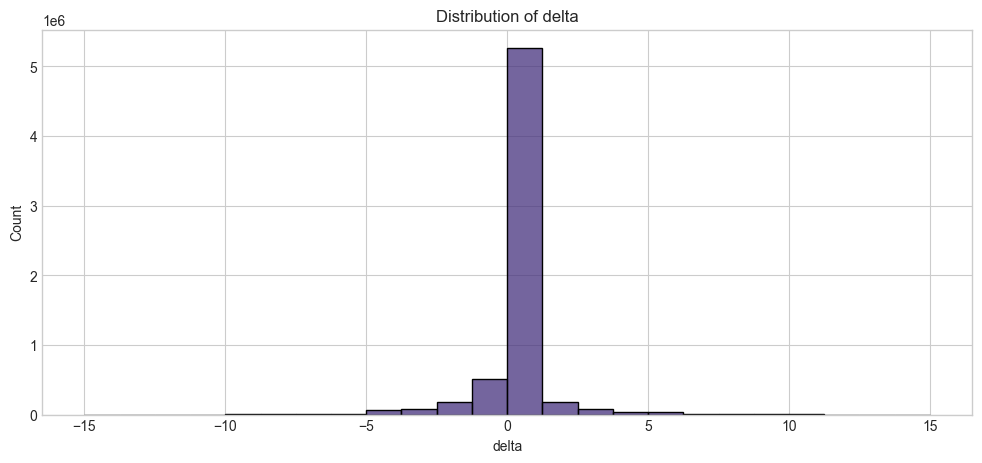

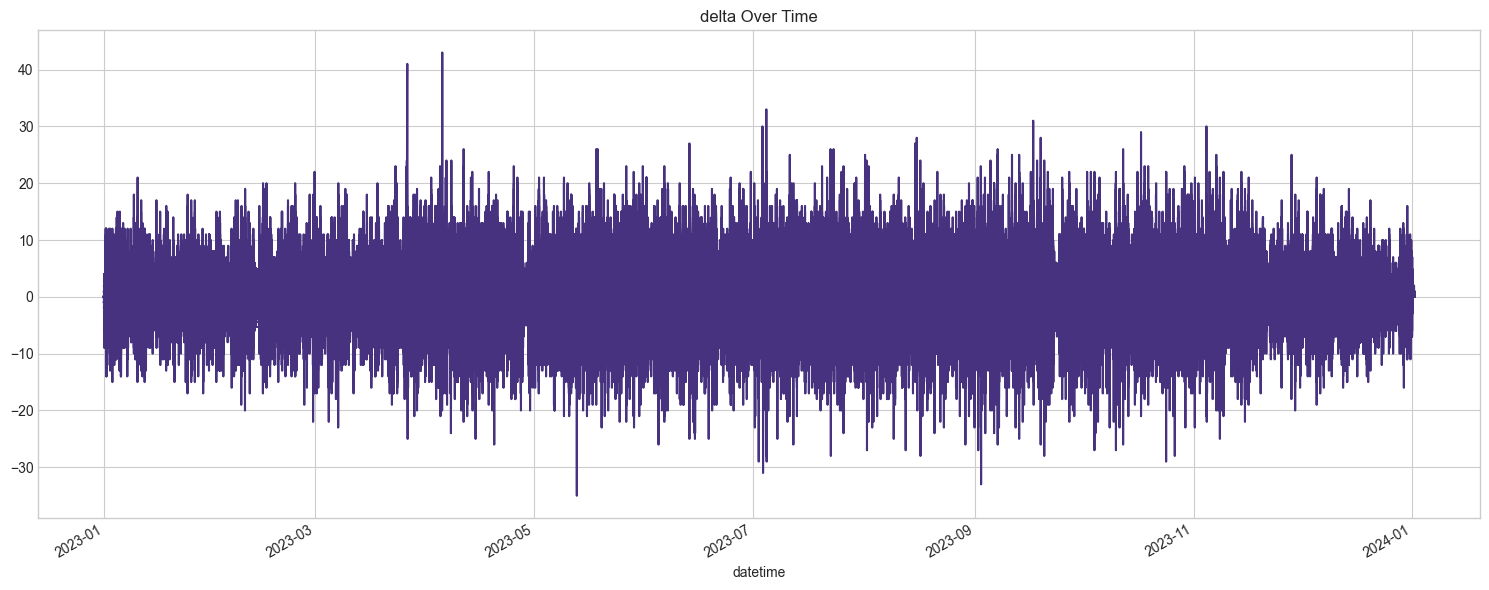

In [9]:
# # Visualize the distribution of the target variable

plt.figure(figsize=(12, 5))
sns.histplot(df_processed[CONFIG['target_col']], binrange=(-12, 12))
plt.title(f'Distribution of {CONFIG["target_col"]}')
plt.show()

# Time series plot of the target
plt.figure(figsize=(15, 6))
df_processed.set_index('datetime')[CONFIG['target_col']].plot()
plt.title(f'{CONFIG["target_col"]} Over Time')
plt.tight_layout()
plt.show()

## Data preparation

In [10]:
df_processed.describe()

,departures,arrivals,temperature_2m,weather_code,rain,precipitation,snowfall,cloud_cover,wind_gusts_10m,wind_speed_10m,...,hour,dayofweek,dayofyear,is_weekend,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos
count,6.476688e+06,6.476688e+06,6.464880e+06,6.464880e+06,6.464880e+06,6.464880e+06,6.464880e+06,6.464880e+06,6.464880e+06,6.464880e+06,...,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06,6.476688e+06
mean,5.608939e-01,5.608939e-01,1.458749e+01,8.251903e+00,1.275649e-01,1.281955e-01,4.415435e-04,5.451659e+01,2.254909e+01,1.041230e+01,...,1.149271e+01,3.002735e+00,1.826682e+02,2.871468e-01,-4.459713e-03,-7.894489e-04,6.984763e-04,-2.893184e-04,3.138260e-05,1.822884e-03
std,1.529350e+00,1.542330e+00,8.825008e+00,1.781920e+01,6.708468e-01,6.714598e-01,1.341518e-02,4.341860e+01,1.083392e+01,5.308391e+00,...,6.920778e+00,2.005688e+00,1.055559e+02,4.524307e-01,7.053179e-01,7.088768e-01,7.070112e-01,7.072021e-01,7.064623e-01,7.077484e-01
min,0.000000e+00,0.000000e+00,-1.001250e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.440000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.999907e-01,-9.999630e-01
25%,0.000000e+00,0.000000e+00,7.379500e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.440000e+01,6.725354e+00,...,5.000000e+00,1.000000e+00,9.100000e+01,0.000000e+00,-8.660254e-01,-8.660254e-01,-7.071068e-01,-7.071068e-01,-7.055836e-01,-7.086267e-01
50%,0.000000e+00,0.000000e+00,1.454300e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.200000e+01,2.052000e+01,9.387650e+00,...,1.100000e+01,3.000000e+00,1.830000e+02,0.000000e+00,-2.449294e-16,-1.836970e-16,1.224647e-16,-1.836970e-16,6.432491e-16,4.303538e-03
75%,0.000000e+00,0.000000e+00,2.168300e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,2.808000e+01,1.304472e+01,...,1.700000e+01,5.000000e+00,2.740000e+02,1.000000e+00,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01,7.055836e-01,7.146734e-01
max,5.700000e+01,5.400000e+01,3.879600e+01,7.500000e+01,2.060000e+01,2.060000e+01,1.400000e+00,1.000000e+02,8.856000e+01,4.093882e+01,...,2.300000e+01,6.000000e+00,3.650000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999907e-01,1.000000e+00


In [11]:
# Prepare data for modeling
def prepare_data(df, target_col, categorical_cols, numerical_cols, drop_cols):
    # Drop rows with NaN
    df_clean = df.dropna()
    
    # Keep datetime for reference
    datetime_col = df_clean['datetime'] if 'datetime' in df_clean.columns else None
    
    # Drop columns defined above
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')
    
    # Split features and target
    X = df_clean[categorical_cols + numerical_cols]
    y = df_clean[target_col]
    
    return X, y, datetime_col

# Test-apply data preparation
X, y, datetime_col = prepare_data(df_processed, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['drop'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
X.head()

Features shape: (6461928, 63)
Target shape: (6461928,)


,isHoliday,has_kiosk,weekday,weather_cluster,workhours,commute,free,night,temperature_2m,rain,...,avg_arrivals_station_free,var_arrivals_station_free,avg_departures_station_free,var_departures_station_free,avg_delta_station_unfriendly_weather,var_delta_station_unfriendly_weather,avg_arrivals_station_unfriendly_weather,var_arrivals_station_unfriendly_weather,avg_departures_station_unfriendly_weather,var_departures_station_unfriendly_weather
4,True,YES,6,precipitation,False,False,True,True,11.936,0.2,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
5,True,YES,6,clear_and_cloudy,False,False,True,True,11.486,0.0,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
6,True,YES,6,clear_and_cloudy,False,True,True,False,11.036,0.0,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
7,True,YES,6,clear_and_cloudy,False,True,True,False,10.786,0.0,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257
8,True,YES,6,clear_and_cloudy,False,True,True,False,10.536,0.0,...,1.317888,4.413823,1.169181,3.7626,-0.083979,4.044215,1.183463,3.703509,1.267442,4.082257


## Modeling
### Pipelines

In [11]:
# Function to create model pipelines for each cluster
def create_model_pipelines(categorical_cols, numerical_cols):
    # Define preprocessing for this cluster
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ], remainder='passthrough')
    
    # Create pipelines
    return {
        'linear': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'polynomial': Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(include_bias=False)),
            ('regressor', LinearRegression())
        ]),
        'decision_tree': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', DecisionTreeRegressor(random_state=CONFIG['random_state']))
        ]),
        'random_forest': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=CONFIG['random_state']))
        ]),
        'xgboost': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=CONFIG['random_state']))
        ]),
        'gbm': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=CONFIG['random_state']))
        ])
    }

# Function to get parameter grids
def get_param_grids():
    return {
        'linear': {}, # No hyperparameters to tune for Lin Reg
        
        'polynomial': {
            'poly__degree': [2, 3]
        },
        
        'decision_tree': {
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10]
        },
        
        'random_forest': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5]
        },
        
        'xgboost': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        },
        
        'gbm': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        }
    }

In [12]:
# Function to plot feature importance
def plot_feature_importance(model_name, model, X):
    # Only for tree-based models
    if not hasattr(model[-1], 'feature_importances_'):
        print(f"Model {model_name} doesn't support feature importance.")
        return
    
    # Get feature names after preprocessing
    if hasattr(model[0], 'get_feature_names_out'):
        # For newer scikit-learn versions
        feature_names = model[0].get_feature_names_out()
    else:
        # Fallback for when feature names aren't available
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    # Extract feature importances
    importance = model[-1].feature_importances_
    
    # Create DataFrame for better visualization
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

In [13]:
# Function to make and visualize predictions
def visualize_predictions(model_name, model, X, y, datetime_col):
    # Make predictions
    y_pred = model.predict(X)
    
    # Create a DataFrame for plotting
    pred_df = pd.DataFrame({
        'datetime': datetime_col,
        'actual': y,
        'predicted': y_pred
    })
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['actual'], label='Actual', alpha=0.7)
    plt.plot(pred_df['datetime'], pred_df['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted (MSE: {mse:.2f}, R²: {r2:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    pred_df['residual'] = pred_df['actual'] - pred_df['predicted']
    
    plt.figure(figsize=(15, 6))
    plt.scatter(pred_df['predicted'], pred_df['residual'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name} - Residuals Plot')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()
    
    return pred_df

### Train

In [14]:
# Function to train and evaluate a single model
def train_evaluate_model(name, pipeline, param_grid, X, y, n_splits):
    print(f"\nTraining {name} model...")
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(
        n_splits=CONFIG['ts_splits'],
        gap=CONFIG['ts_gap'])
    
    # GridSearch with time series split
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=CONFIG['n_jobs'],
        verbose=0
    )
    
    grid_search.fit(X, y)
    
    # Store results
    best_model = grid_search.best_estimator_
    result = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'rmse': np.sqrt(-grid_search.best_score_)
    }
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  MSE: {-grid_search.best_score_:.4f}")
    print(f"  RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
    
    return best_model, result

In [15]:
def prepare_cluster_data(cluster_id, df_processed):
    """Extract and prepare data for a specific cluster"""
    cluster_df = df_processed[df_processed['cluster'] == cluster_id].copy()
    return prepare_data(cluster_df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['drop'])

def train_cluster_models(X, y, models_to_train):
    """Train all selected models for a cluster"""
    best_models = {}
    results = {}
    
    pipelines = create_model_pipelines(FEATURE_COLS['categorical'], FEATURE_COLS['numerical'])
    param_grids = get_param_grids()
    
    for model_name in models_to_train:
        if model_name in pipelines:
            best_models[model_name], results[model_name] = train_evaluate_model(
                model_name, pipelines[model_name], param_grids[model_name], X, y
            )
    
    return best_models, results

def create_comparison_df(results_dict):
    """Creates a DataFrame comparing model performance metrics."""
    comparison = pd.DataFrame({
        'Model': list(results_dict.keys()),
        'RMSE': [results_dict[m]['rmse'] for m in results_dict.keys()]
    }).sort_values('RMSE')
    
    return comparison

In [16]:
# Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Function to train models for a single cluster
def train_models_for_cluster(cluster_id, df_processed, models_to_train):
    # Print heading
    print(f"\n{'='*50}")
    print(f"Training models for Cluster {cluster_id}")
    print(f"{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col_cluster = prepare_cluster_data(cluster_id, df_processed)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    best_models_cluster, results_cluster = train_cluster_models(X_cluster, y_cluster, models_to_train)
    
    # Compare models for this cluster
    comparison_cluster = pd.DataFrame({
        'Model': list(results_cluster.keys()),
        'RMSE': [results_cluster[m]['rmse'] for m in results_cluster.keys()]
    }).sort_values('RMSE')
    
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    # for model_name in ['random_forest', 'xgboost', 'gbm']:
    #     if model_name in best_models_cluster:
    #         print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
    #         feature_imp = plot_feature_importance(model_name, best_models_cluster[model_name], X_cluster)
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    # if best_model_name in best_models_cluster:
    #     pred_df = visualize_predictions(
    #         f"{best_model_name} (Cluster {cluster_id})", 
    #         best_models_cluster[best_model_name], 
    #         X_cluster, y_cluster, datetime_col_cluster
    #     )
    
    return best_models_cluster, results_cluster, comparison_cluster

In [17]:
#models_to_train = ['linear', 'polynomial', 'xgboost', 'decision_tree', 'random_forest', 'gbm']
models_to_train = ['linear', 'xgboost', 'decision_tree', 'gbm']

# Get unique clusters
unique_clusters = df_processed['cluster'].unique()
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# Train models for each cluster
for cluster_id in unique_clusters:
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col = prepare_cluster_data(cluster_id, df_processed)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(X_cluster, y_cluster, models_to_train)
    
    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
    
    # Visualize results
    if CONFIG['visualize_clusters']:
        visualize_cluster_results(cluster_id, models, X_cluster, y_cluster) # TODO

Found 5 clusters: [2 4 5 3 1]

Processing Cluster 2


NameError: name 'prepare_data' is not defined

In [ ]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()